<a href="https://colab.research.google.com/github/nvarasp/FinalProject_IRWA/blob/main/notebook/RQ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RQ1


### 0- Imports and configuration

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Insert the directory
import sys
sys.path.insert(0,"/content/drive/My Drive/IRWA/FinalProject/notebook/")

In [3]:
from functions_v3 import *
from gensim.models import Word2Vec
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import operator
import ast
import csv
import json 
import_jsons="/content/drive/My Drive/IRWA/FinalProject/notebook/"  
STOPWORDS = set(stopwords.words("english"))


In [5]:
#Read the panda dataframe resulting from preprocessing the tweets in the search engine
df_proc = pd.read_csv(import_jsons+'df_proc.csv')
df_proc['Tweet_proc'] = [list(ast.literal_eval(x)) for x in df_proc['Tweet_proc']]

In [6]:
#Creating the index 
start_time = time.time()
numDocuments = len(df_proc["Tweet_proc"])
index, tf, df, idf= create_tf_idf_index(df_proc,"Tweet_proc", numDocuments)

### 1- Getting top-20 list of documents for 10 queries using tf-idf + cosine similarity

In [7]:
with open('/content/drive/My Drive/IRWA/FinalProject/other-outputs/output_RQ1_b.tsv', 'wt') as out_file:
  tsv_writer = csv.writer(out_file, delimiter='\t')
  for i in range (0,10):
    print("\n Insert your query:\n")
    query = input()
    ranked_docs = search_tf_idf(query, index, tf, idf)    
    top = 20
    num_results=min(len(ranked_docs), top)

    print("\n======================\nTop {} results out of {} for the seached query:\n".format(num_results, len(ranked_docs)))
    tsv_writer.writerow(["QUERY: ", query])
    tsv_writer.writerow(["Ranking", "Tweet", "Text", "Username", "Date", "URL", "Retweets", "Likes", "Hashtags"])
    tsv_writer.writerow([" "])
    
    n=1
    for d_id in ranked_docs[:num_results]:
      tsv_writer.writerow([n, d_id, df_proc.iloc[d_id][0], df_proc.iloc[d_id][1], df_proc.iloc[d_id][2], df_proc.iloc[d_id][6], df_proc.iloc[d_id][5], df_proc.iloc[d_id][4], df_proc.iloc[d_id][3]])
      print("{} tweet: {} \n".format(n, d_id))
      print("Text: {}.\n".format(df_proc.iloc[d_id][0]))
      print("Username: {}. Date: {}. URL: {}\n".format(df_proc.iloc[d_id][1], df_proc.iloc[d_id][2], df_proc.iloc[d_id][6]))
      print("Retweets: {}. Likes: {}. Hashtags: {}\n".format(df_proc.iloc[d_id][5], df_proc.iloc[d_id][4], df_proc.iloc[d_id][3]))
      print("\n")
      n+=1
          


 Insert your query:

I got covid

Top 20 results out of 86 for the seached query:

1 tweet: 9565 

Text: Engineer got covid and I got some heat. I-.

Username: Only_Gregory. Date: Wed Dec 16 22:13:52 +0000 2020. URL: https://twitter.com/twitter/statuses/1339332945530810371

Retweets: 0. Likes: 0. Hashtags: []



2 tweet: 110 

Text: one of my friends got covid &amp; he’s got it bad 😩.

Username: midast0uuch. Date: Wed Nov 18 10:19:20 +0000 2020. URL: https://twitter.com/twitter/statuses/1329006268929900544

Retweets: 0. Likes: 0. Hashtags: []



3 tweet: 9521 

Text: my plug got covid 😒🙄.

Username: theaveragejooo. Date: Wed Dec 16 22:13:49 +0000 2020. URL: https://twitter.com/twitter/statuses/1339332932935233536

Retweets: 0. Likes: 0. Hashtags: []



4 tweet: 13159 

Text: That stove got COVID https://t.co/Q4K3OgKSIA.

Username: weszmarsh. Date: Wed Dec 16 22:17:32 +0000 2020. URL: https://twitter.com/twitter/statuses/1339333869905043460

Retweets: 0. Likes: 0. Hashtags: []



5 twe

### 2- Getting top-20 list of documents for 10 queries using word2vec + cosine similarity

#### Defining word2vec, rank and search functions

In [8]:
#get all the tweets
sentences=df_proc['Tweet_proc'].values.tolist()

In [9]:
#computing word2vec, so that each word is respresented by a vector
size=50 #or 100
#word2vec = Word2Vec(sentences, size=100, window=10, min_count=1, negative=15, sg=0)
word2vec = Word2Vec(sentences, min_count = 1, size = size, window = 10, negative=15, sg=0) 

words = list(word2vec.wv.vocab)


In [10]:
def rankDocumentsWord2vec(terms, docs, index, idf, tf, size):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted tweet frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked tweets
    """
    resultDocs=[]
    
    doc_scores=[]
    query_vector=np.zeros(100)
    query_words=0
    query_vector=0
    tweet_vectors_dic={}
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
      if term in word2vec.wv.vocab:
        query_vector+= word2vec[term]
        query_words+=1
    query_vector=query_vector/query_words
    
    for doc_id in docs:
      tweet_vector = np.zeros(size)
      tweet_vectors_dic[doc_id]=np.zeros(size)
      words=0
      for word in df_proc.iloc[doc_id][7]:    
        if word in word2vec.wv.vocab:
          tweet_vector = tweet_vector + word2vec[word]
          tweet_vectors_dic[doc_id]=tweet_vectors_dic[doc_id]+ word2vec[word]
          words+=1
      tweet_vector=tweet_vector/words
      #print("Tweet",doc_id, "vector: ", tweet_vector) 
      tweet_vectors_dic[doc_id]=tweet_vectors_dic[doc_id]/words 
      doc_scores.append([cosine_similarity(np.array(query_vector).reshape(1, -1),np.array( tweet_vectors_dic[doc_id]).reshape(1, -1)), doc_id])
    
    doc_scores.sort(reverse=True)
    resultDocs=[x[1] for x in doc_scores]
    
    while len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        resultDocs = search_tf_idf(query, index, tf, idf) 

    return resultDocs

In [11]:
def search_word2vec(query, index, size):

    '''
    output is the list of tweets that contain all of the query terms. 
    So, we will get the list of tweets for each query term, and take the and of them.
    '''
    query=getTerms(query)
    docs= set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]

            if len(docs)==0:
              docs = set(termDocs)
            else:
              docs= docs & set(termDocs)
            # docs = docs Union termDocs
           
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocumentsWord2vec(query, docs, index, idf, tf, size)   
    return ranked_docs
  

####Queries

In [12]:
with open('/content/drive/My Drive/IRWA/FinalProject/other-outputs/output_RQ1_c.tsv', 'wt') as out_file:
  tsv_writer = csv.writer(out_file, delimiter='\t')
  for i in range (0,10):
    print("\n Insert your query:\n")
    query = input()
    ranked_docs = search_word2vec(query, index, size)       
    top = 20
    num_results=min(len(ranked_docs), top)

    print("\n======================\nTop {} results out of {} for the seached query:\n".format(num_results, len(ranked_docs)))
    tsv_writer.writerow(["QUERY: ", query])
    tsv_writer.writerow(["Ranking", "Tweet", "Text", "Username", "Date", "URL", "Retweets", "Likes", "Hashtags"])
    tsv_writer.writerow([" "])
    
    n=1
    for d_id in ranked_docs[:num_results]:
      tsv_writer.writerow([n, d_id, df_proc.iloc[d_id][0], df_proc.iloc[d_id][1], df_proc.iloc[d_id][2], df_proc.iloc[d_id][6], df_proc.iloc[d_id][5], df_proc.iloc[d_id][4], df_proc.iloc[d_id][3]])
      print("{} tweet: {} \n".format(n, d_id))
      print("Text: {}.\n".format(df_proc.iloc[d_id][0]))
      print("Username: {}. Date: {}. URL: {}\n".format(df_proc.iloc[d_id][1], df_proc.iloc[d_id][2], df_proc.iloc[d_id][6]))
      print("Retweets: {}. Likes: {}. Hashtags: {}\n".format(df_proc.iloc[d_id][5], df_proc.iloc[d_id][4], df_proc.iloc[d_id][3]))
      print("\n")
      n+=1


 Insert your query:

I got covid

Top 20 results out of 86 for the seached query:

1 tweet: 13159 

Text: That stove got COVID https://t.co/Q4K3OgKSIA.

Username: weszmarsh. Date: Wed Dec 16 22:17:32 +0000 2020. URL: https://twitter.com/twitter/statuses/1339333869905043460

Retweets: 0. Likes: 0. Hashtags: []



2 tweet: 9521 

Text: my plug got covid 😒🙄.

Username: theaveragejooo. Date: Wed Dec 16 22:13:49 +0000 2020. URL: https://twitter.com/twitter/statuses/1339332932935233536

Retweets: 0. Likes: 0. Hashtags: []



3 tweet: 11684 

Text: @MustafaSammor OMFG 💀 you ain’t got covid no more.

Username: kellyanne199720. Date: Wed Dec 16 22:16:02 +0000 2020. URL: https://twitter.com/twitter/statuses/1339333490077278208

Retweets: 0. Likes: 0. Hashtags: []



4 tweet: 13272 

Text: JUST GOT MY RESULTS I DONT HAVE COVID WOOHOO.

Username: needypov. Date: Wed Dec 16 22:17:41 +0000 2020. URL: https://twitter.com/twitter/statuses/1339333907288895490

Retweets: 0. Likes: 2. Hashtags: []



5 

### 3- Representing the tweets in a 2D scatter plot through the t-sne algorithm

**SMALL REMARK:**
To perform this part of the project that includes the clustering and 2d representation, we have selected a smaller subset of the dataset that contains 16k tweets, since running the code with the big one took a lot of time. This is not a problem for the task since the quantity is good enough to provide interesting insights about the tweets distributions. So here we read the dataframe of this subset of tweets. 


In [13]:
df_proc = pd.read_csv('/content/drive/My Drive/IRWA/FinalProject/notebook/df_to_cluster.csv')
df_proc['Tweet_proc'] = [list(ast.literal_eval(x)) for x in df_proc['Tweet_proc']]

In [14]:
#get all the tweets
sentences=df_proc['Tweet_proc'].values.tolist()
#computing word2vec, so that each word is respresented by a vector
size=50 #or 100
#word2vec = Word2Vec(sentences, size=100, window=10, min_count=1, negative=15, sg=0)
word2vec = Word2Vec(sentences, min_count = 1, size = size, window = 10, negative=15, sg=0) 

words = list(word2vec.wv.vocab)


In [15]:
tweet_vectors_dic={}#dictonary of vectors of tweets
tweet_vectors_list=[]#list of vectors of all tweets
for i, tweet in df_proc.iterrows():
  tweet_vectors_dic[i]=0
  words=0
  for word in df_proc.iloc[i][7]:  
    if word in word2vec.wv.vocab:
      tweet_vectors_dic[i]=tweet_vectors_dic[i]+ word2vec[word]
      words+=1
  
  tweet_vectors_dic[i]=tweet_vectors_dic[i]/words
  tweet_vectors_list.append(tweet_vectors_dic[i])

####Clustering the tweets

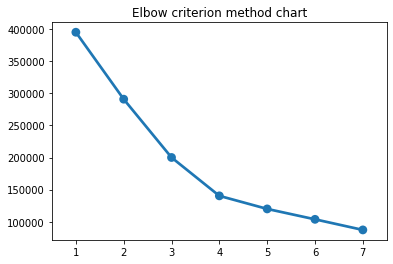

In [16]:
#Choosing optimal number of clusters based on elbow method
sse={}
for num_clusters in list(range(1,8)):
    kmeans = KMeans(n_clusters=num_clusters, random_state=333)
    kmeans.fit(tweet_vectors_list)
    sse[num_clusters]=kmeans.inertia_

plt.title("Elbow criterion method chart")
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()


We have seen that the optimal number of clusters for these tweets is 4. So we will cluster using kmeans with 4 clusters. 

In [17]:
#tweet_vectors_list contains the list of vector of all tweets
#so we apply TSNE algorithm to this list
X=tweet_vectors_list
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
#X_tsne contains now the vectors in 2dimensions for all the tweets

In [18]:
n_clusters=4

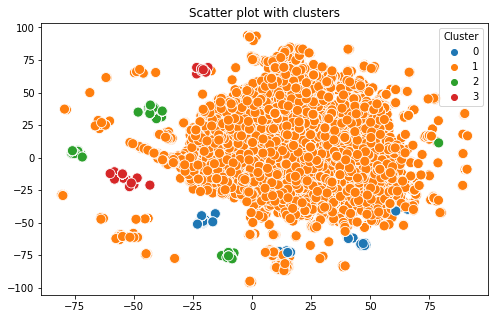

In [19]:
#clustering = AgglomerativeClustering(n_clusters=4,linkage="ward").fit_predict(tweet_vectors_list)
kmeans=KMeans(n_clusters=n_clusters)
kmeans.fit(tweet_vectors_list)
clustering=kmeans.labels_

cluster_data = pd.DataFrame(df_proc)
cluster_data["Cluster"]=clustering
#cluster_data.head()

fig = plt.figure(figsize=(8,5))
sns.scatterplot(data=cluster_data, x=X_tsne[:, 0], y=X_tsne[:, 1], hue="Cluster", s=100, palette=sns.color_palette("tab10",n_clusters))
plt.title("Scatter plot with clusters")
plt.show()

####Showing plots for each cluster

In [20]:
def get_bagofwords(data, attribute):
  bag_of_words = {}
  for tweet in data[attribute]:
    for text in tweet:
      # remove "RT" string indicating a retweet
      text = text.replace("RT", "").strip()
      text = text.replace("#", "").strip()
      # lowering text
      text = text.lower()
      
      # removing all the punctuations
      text = re.sub(r'[^\w\s]','',text).strip()
      text= text.encode('ascii', 'ignore').decode('ascii')
      
      # tokenize the text
      lst_text = text.split()
      
      # remove stopwords
      lst_text = [x for x in lst_text if x not in STOPWORDS]
      
          
      # create bag-of-words - for each word the frequency of the word in the corpus
      for w in lst_text:
          if w not in bag_of_words:
              bag_of_words[w] = 0
          bag_of_words[w]+=1
  return bag_of_words

In [21]:
def plot_wordcloud(title, dic_):
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    wordcloud = WordCloud(background_color="white",width=1600, height=800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation='bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

In [22]:
def plot_barplot(bag_of_words):
  frequent_words=sorted(bag_of_words.items(), key=operator.itemgetter(1), reverse=True)

  x, y = zip(*frequent_words[:10])
  plt.barh(x,y)
  plt.xlabel("Count")
  plt.ylabel("Words")
  plt.title("Bar plot of most frequent words")

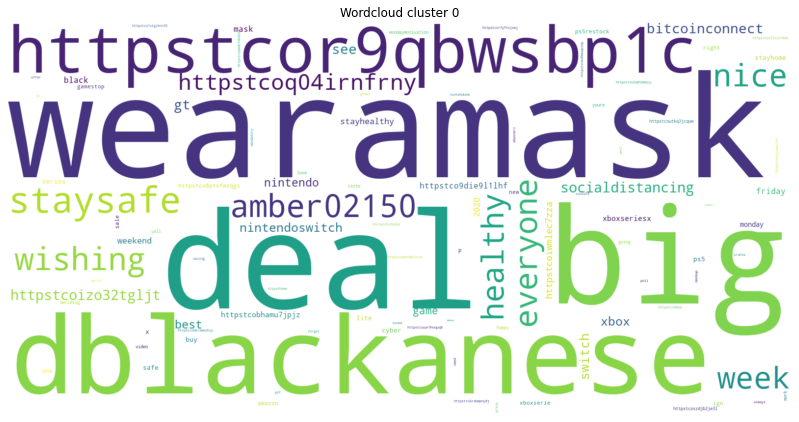

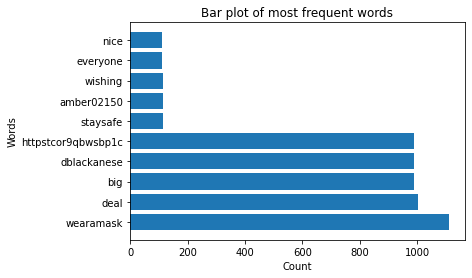

In [23]:
STOPWORDS = set(stopwords.words("english"))
bag_of_words=get_bagofwords(cluster_data[cluster_data['Cluster'] == 0], "Tweet_proc")
plot_wordcloud("Wordcloud cluster 0", bag_of_words)
plot_barplot(bag_of_words)

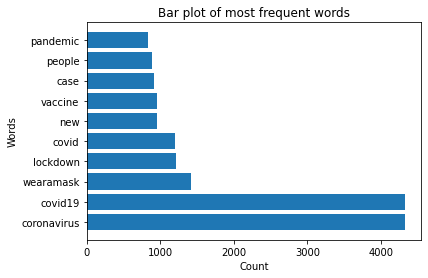

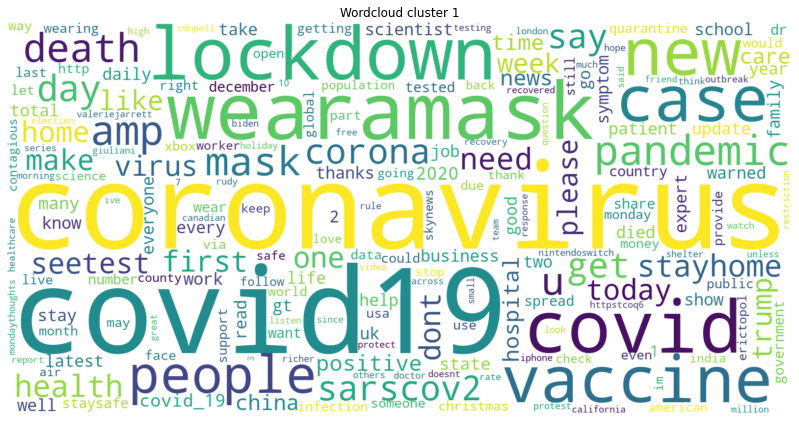

In [24]:
bag_of_words=get_bagofwords(cluster_data[cluster_data['Cluster'] == 1], "Tweet_proc")
plot_barplot(bag_of_words)
plot_wordcloud("Wordcloud cluster 1", bag_of_words)


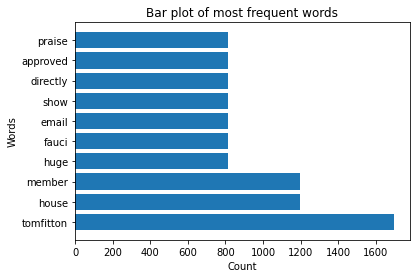

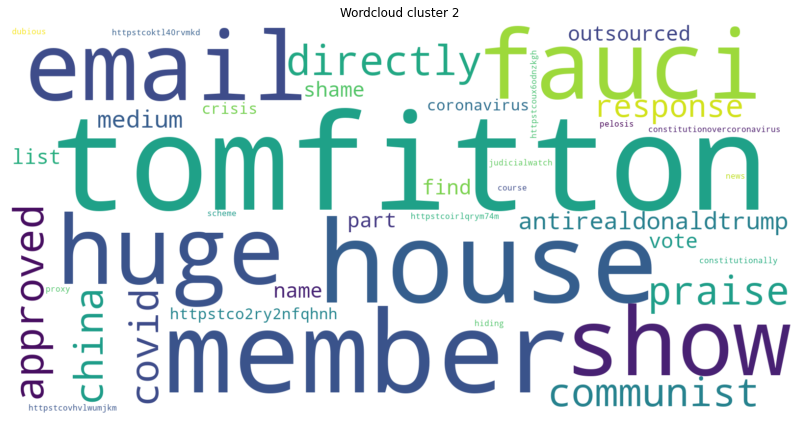

In [25]:
bag_of_words=get_bagofwords(cluster_data[cluster_data['Cluster'] == 2], "Tweet_proc")
plot_barplot(bag_of_words)
plot_wordcloud("Wordcloud cluster 2", bag_of_words)


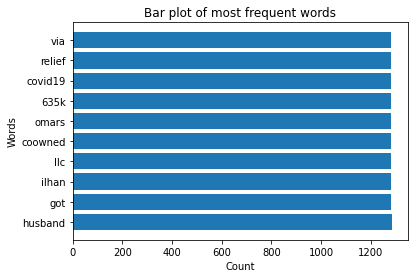

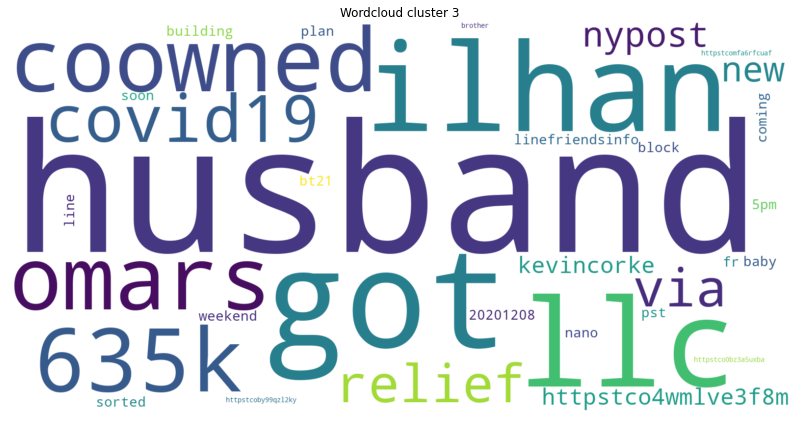

In [26]:
bag_of_words=get_bagofwords(cluster_data[cluster_data['Cluster'] == 3], "Tweet_proc")
plot_barplot(bag_of_words)
plot_wordcloud("Wordcloud cluster 3", bag_of_words)

In [27]:
cluster_data

,Tweet,Username,Date,Hashtags,Likes,Retweets,Url,Tweet_proc,Cluster
0,@JoeBiden R/T IF YOU AGREE!!\n#JoeBidenKamalaH...,SarxClothing_,Mon Dec 07 12:37:55 +0000 2020,"[{'text': 'JoeBidenKamalaHarris2020', 'indices...",0,0,https://twitter.com/twitter/statuses/133592651...,"[joebiden, rt, agree, joebidenkamalaharris2020...",1
1,RT @dblackanese: It’s a very big deal. \n#Wear...,nightnum9,Mon Dec 07 12:37:55 +0000 2020,"[{'text': 'WearAMask', 'indices': [40, 50]}]",0,4400,https://twitter.com/twitter/statuses/133592651...,"[dblackanese, big, deal, wearamask, httpstcor9...",0
2,RT @Amber02150: Wishing everyone a nice health...,jackwen5566,Mon Dec 07 12:37:55 +0000 2020,"[{'text': 'StaySafe', 'indices': [55, 64]}, {'...",0,400,https://twitter.com/twitter/statuses/133592651...,"[amber02150, wishing, everyone, nice, healthy,...",0
3,RT @dblackanese: It’s a very big deal. \n#Wear...,jmcmichael2017,Mon Dec 07 12:37:56 +0000 2020,"[{'text': 'WearAMask', 'indices': [40, 50]}]",0,4400,https://twitter.com/twitter/statuses/133592651...,"[dblackanese, big, deal, wearamask, httpstcor9...",0
4,@JoeBiden R/T IF YOU AGREE!!\n#JoeBidenKamalaH...,SarxClothing_,Mon Dec 07 12:37:57 +0000 2020,"[{'text': 'JoeBidenKamalaHarris2020', 'indices...",0,0,https://twitter.com/twitter/statuses/133592652...,"[joebiden, rt, agree, joebidenkamalaharris2020...",1
...,...,...,...,...,...,...,...,...,...
16639,RT @larryelder: California Riverside Sheriff C...,putchie61,Mon Dec 07 16:23:59 +0000 2020,"[{'text': 'GavinNewsom', 'indices': [114, 126]...",0,107,https://twitter.com/twitter/statuses/133598340...,"[larryelder, california, riverside, sheriff, c...",1
16640,#Measurementsmatter - now maybe even more than...,ElkeH1,Mon Dec 07 16:23:36 +0000 2020,"[{'text': 'Measurementsmatter', 'indices': [0,...",6,0,https://twitter.com/twitter/statuses/133598330...,"[measurementsmatter, maybe, even, ever, thats,...",1
16641,Which local pubs have decent outside areas wit...,Barney71,Mon Dec 07 16:23:46 +0000 2020,"[{'text': 'lockdown', 'indices': [84, 93]}, {'...",0,0,https://twitter.com/twitter/statuses/133598334...,"[local, pub, decent, outside, area, heating, a...",1
16642,RT @bopanc: The Swedish #Covid-19 experiment i...,namshine,Mon Dec 07 16:23:53 +0000 2020,"[{'text': 'Covid', 'indices': [24, 30]}, {'tex...",0,824,https://twitter.com/twitter/statuses/133598337...,"[bopanc, swedish, covid19, experiment, severe,...",1


In [28]:
save_json="/content/drive/My Drive/IRWA/FinalProject/notebook/"
cluster_data.to_csv(save_json+"clustered_data.csv", index=True)